In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [12]:
# Hyperparameters
batch_size = 128
latent_dim = 20
epochs = 20
lr = 1e-3

# MNIST Dataset
transform = transforms.ToTensor()

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [13]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Output between 0 and 1 for BCE

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [14]:
# Loss functions

def loss_function_bce(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE.item(), KLD.item()

def loss_function_mse(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, MSE.item(), KLD.item()


In [15]:
# Training function
def train_vae(model, optimizer, train_loader, loss_fn, epochs=20):
    model.train()
    train_loss_list = []
    recon_loss_list = []
    kld_loss_list = []

    for epoch in range(epochs):
        train_loss = 0
        recon_loss_epoch = 0
        kld_loss_epoch = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, recon_l, kld_l = loss_fn(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            recon_loss_epoch += recon_l
            kld_loss_epoch += kld_l
            optimizer.step()

        avg_loss = train_loss / len(train_loader.dataset)
        avg_recon = recon_loss_epoch / len(train_loader.dataset)
        avg_kld = kld_loss_epoch / len(train_loader.dataset)

        train_loss_list.append(avg_loss)
        recon_loss_list.append(avg_recon)
        kld_loss_list.append(avg_kld)

        print(f'Epoch {epoch+1}, Total Loss: {avg_loss:.4f}, Recon Loss: {avg_recon:.4f}, KLD Loss: {avg_kld:.4f}')
    return train_loss_list, recon_loss_list, kld_loss_list


In [16]:
vae_bce = VAE(latent_dim).to(device)
optimizer_bce = optim.Adam(vae_bce.parameters(), lr=lr)

vae_mse = VAE(latent_dim).to(device)
optimizer_mse = optim.Adam(vae_mse.parameters(), lr=lr)

print("Training VAE with BCE Reconstruction Loss...")
bce_total_loss, bce_recon_loss, bce_kld_loss = train_vae(vae_bce, optimizer_bce, train_loader, loss_function_bce, epochs=epochs)

print("\nTraining VAE with MSE Reconstruction Loss...")
mse_total_loss, mse_recon_loss, mse_kld_loss = train_vae(vae_mse, optimizer_mse, train_loader, loss_function_mse, epochs=epochs)


Training VAE with BCE Reconstruction Loss...
Epoch 1, Total Loss: 165.3523, Recon Loss: 150.0969, KLD Loss: 15.2553
Epoch 2, Total Loss: 122.5080, Recon Loss: 100.5020, KLD Loss: 22.0060
Epoch 3, Total Loss: 115.0294, Recon Loss: 91.1013, KLD Loss: 23.9281
Epoch 4, Total Loss: 111.9045, Recon Loss: 87.3668, KLD Loss: 24.5378
Epoch 5, Total Loss: 110.1325, Recon Loss: 85.2983, KLD Loss: 24.8342
Epoch 6, Total Loss: 108.9031, Recon Loss: 83.9197, KLD Loss: 24.9834
Epoch 7, Total Loss: 108.0466, Recon Loss: 82.9773, KLD Loss: 25.0693
Epoch 8, Total Loss: 107.4222, Recon Loss: 82.2098, KLD Loss: 25.2124
Epoch 9, Total Loss: 106.8778, Recon Loss: 81.6265, KLD Loss: 25.2513
Epoch 10, Total Loss: 106.4178, Recon Loss: 81.1145, KLD Loss: 25.3033
Epoch 11, Total Loss: 106.1244, Recon Loss: 80.7324, KLD Loss: 25.3921
Epoch 12, Total Loss: 105.7449, Recon Loss: 80.3452, KLD Loss: 25.3997
Epoch 13, Total Loss: 105.5165, Recon Loss: 80.0798, KLD Loss: 25.4367
Epoch 14, Total Loss: 105.1866, Recon L

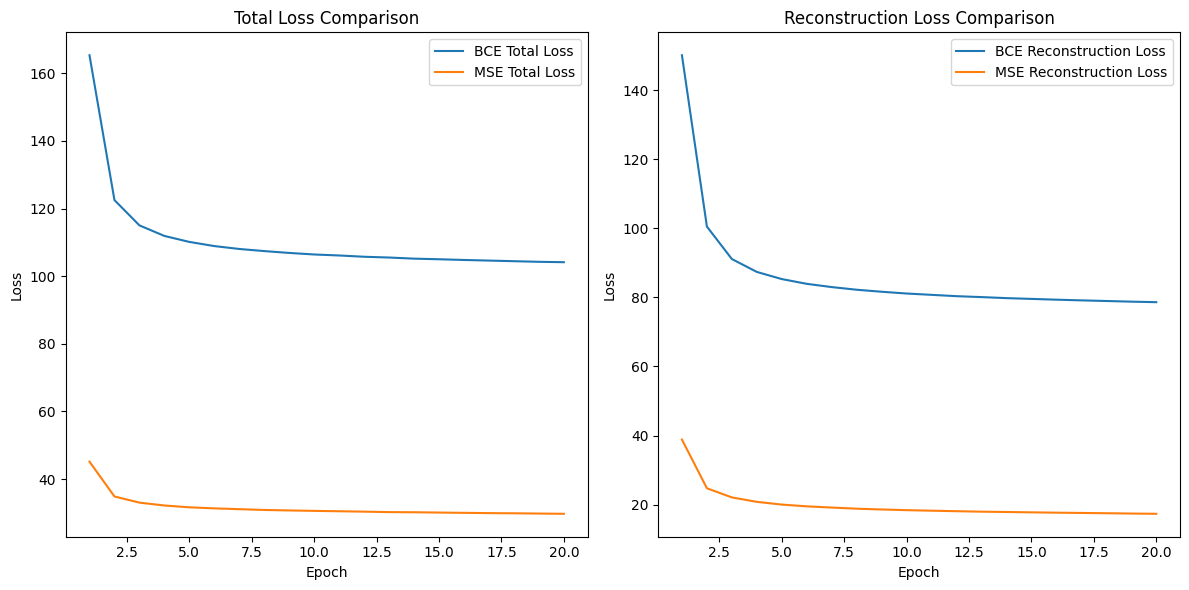

In [17]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), bce_total_loss, label='BCE Total Loss')
plt.plot(range(1, epochs+1), mse_total_loss, label='MSE Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss Comparison')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), bce_recon_loss, label='BCE Reconstruction Loss')
plt.plot(range(1, epochs+1), mse_recon_loss, label='MSE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reconstruction Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()